In [1]:
# Check if running in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  

In [2]:
if IN_COLAB :
    # If we are in colab we don't have access to our custom modules so we clone the repository
    !git clone https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor.git
    # Pull last data from git
    !cd clothes-extractor && git pull && cd ..
%

UsageError: Line magic function `%` not found.


In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [5]:
if '_dh' in dict(globals()):
  # Import code form our github
  from pathlib import Path

  current_folder = globals()['_dh'][0]
  print(current_folder)
  # parent = Path(current_folder).parent
  # os.chdir(str(parent))
  os.chdir("/notebooks/clothes-extractor")
  print(os.getcwd())

  
# Project imports
from dataset import ClothesDataLoader, ClothesDataset
from config import Config
from models.unet import Unet
from trainer.trainer import train_model

/notebooks
/notebooks/clothes-extractor/src


In [ ]:
seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
# torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [ ]:
# import torch.multiprocessing as mp

# mp.set_start_method('spawn')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

cuda


In [ ]:
# Type here the path for the data set
dataset_path = os.path.join("datasets", "zalando-hd-resized")
!pwd

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  !wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  !echo "Extracting the dataset. Please wait...."
  !unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  !rm path_check.tmp
  !rm zalando-hd-resized.zip
  print("Done")

/notebooks/clothes-extractor
Dataset already downloaded


In [ ]:
cfg = Config()
cfg.batch_size = 32
cfg.dataset_dir = dataset_path
cfg.load_height = 28
cfg.load_width = 28
cfg.learning_rate = 0.0001
cfg.num_epochs = 1
cfg.num_val_samples = 10
cfg.num_input_channels = 1
cfg.num_classes = 10
cfg.workers = 0
cfg.max_batches = 1000
cfg.angle_prob = 0

In [ ]:

test_dataset = ClothesDataset(cfg, "test", device=device)
train_dataset = ClothesDataset(cfg, "train", device=device)

test_dataloader = ClothesDataLoader(test_dataset, cfg.batch_size, num_workers=cfg.workers)
train_dataloader = ClothesDataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


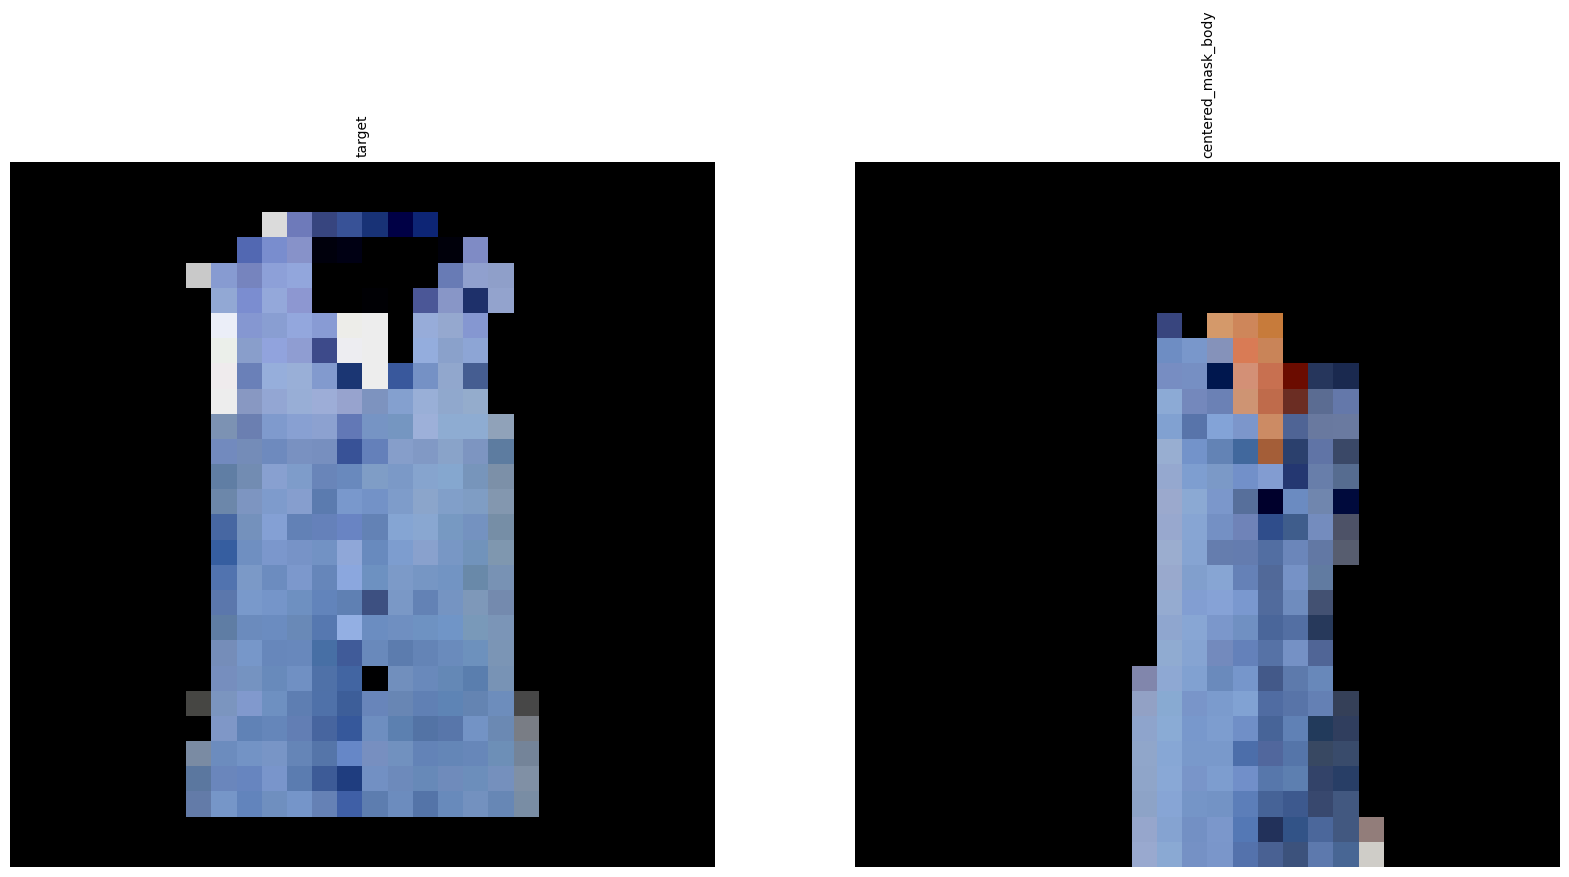

In [ ]:
image = train_dataset[13]

# image_keys = ["img", "cloth", "cloth_mask", "predict", "agnostic_mask", "mask_body_parts", "mask_body", "centered_mask_body", "img_masked"]
image_keys = ["target", "centered_mask_body"]
fig, axes = plt.subplots(1, len(image_keys), figsize=(20, 20))

for ax, key in zip(axes, image_keys):
    ax.imshow(image[key].cpu().permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(key, rotation=90, fontsize=10)

# Defining the UNET
![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

We are using the Unet defined in the [Model module from the repository](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/model.py)

In [ ]:

def visualize_nn_output(output, device, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()

    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = np.transpose(output, (1, 2, 0))

    plt.imshow(output)
    plt.show()

In [ ]:
model = Unet(in_channels=3, n_feat=32).to(device)
# model = torch.load('best2.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


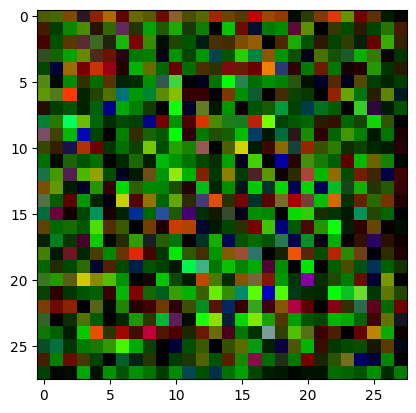

In [ ]:
inp = torch.randn(2,3,cfg.load_height,cfg.load_width).to(device) #As a sanity check, we define a random tensor with the same shape as an input image, to make sure that we can forward it to our network
out = model(inp)

visualize_nn_output(out, device)

In [ ]:
inp = torch.randn(2,64,28,28).to(device)
out = model.to_vec(inp)
print(out.shape)
out = model.up0(out)
print(out.shape)

torch.Size([2, 64, 4, 4])
torch.Size([2, 64, 28, 28])


The Train model function is the defined in the [train module from the project](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/train.py)


In [ ]:
def run_model_on_image(model, device, dataset, image_index):
    model.eval()
    
    image = dataset[image_index]
    image = image["centered_mask_body"].to(device).unsqueeze(0)

    
    with torch.no_grad():
        output = model(image)

    return output


In [ ]:
# For testing purposes (There are so many images) we can limit the number of loaded batches, 0 is no limit
cfg.max_batches = 0

trained_model = train_model(model, device, train_dataloader, test_dataloader, cfg.num_epochs, cfg.learning_rate, cfg.max_batches)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!ls
!nvidia-smi

Dockerfile  LICENSE    best5.pth  docs		    src
Jupyters    README.md  datasets   requirements.txt
Sun Feb  4 18:54:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   44C    P8    16W / 140W |  11343MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


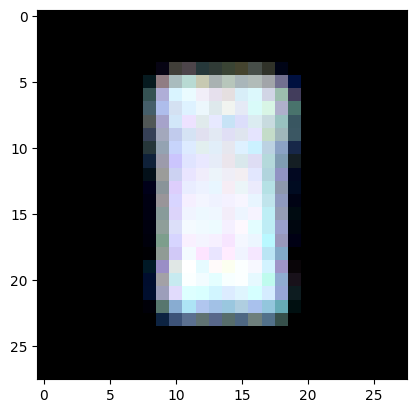

In [ ]:
model = torch.load('best5.pth')
out = run_model_on_image(model, device, train_dataset, 2)
visualize_nn_output(out, device)

In [ ]:
torch.save(model, 'best5.pth')

In [ ]:
import src.dataset as dataset
import importlib
importlib.reload(dataset)

In [ ]:
model

In [ ]:
from tqdm import tqdm
import time

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    time.sleep(1)

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


In [ ]:
get_ipython().__class__.__name__

'ZMQInteractiveShell'